In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV


# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación
Mostramos una muestra de los datos, al igual que información general y cuantitativa de los datos, para tener una idea general del dataframe.

In [2]:
data = pd.read_csv("./taxi.csv")
data.info()
display(data.describe())
display(data.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


De forma rutinaria, nos aseguramos que no haya valores vaciós ni duplicados:

In [3]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

Notamos que:
- es necesario cambiar el tipo de dato de la columna "datetime".
- posteriormente usar la columna "datetime" como indices del dataframe.
- nos aseguraremos de ordenar cronologicamente los nuevos inices.
- las columnas estan bien nombradas.

In [4]:
data["datetime"]=data["datetime"].astype("datetime64[ns]")
print(data["datetime"].is_monotonic_increasing)
data.set_index("datetime",inplace=True)
data.sort_index(inplace=True)

True


In [5]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Procedemos a hacer el re-muestreo a una hora con un grafico para ver su efecto.

Como los datos abarcan un gran periodo de tiempo, tomaremos un dia arbitrario para visualizar.

<Axes: title={'center': 'despues del re muestreo'}, xlabel='datetime'>

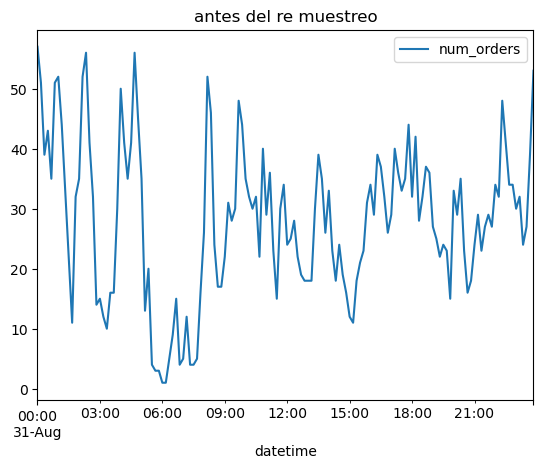

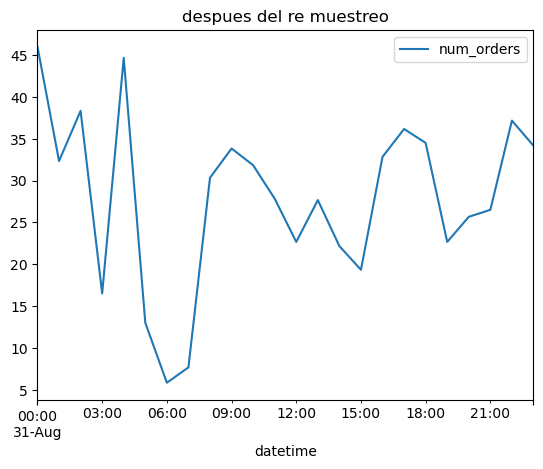

In [6]:

data["2018-08-31":"2018-08-31"].plot(title="antes del re muestreo")
data=data.resample("1h").mean()
data["2018-08-31":"2018-08-31"].plot(title="despues del re muestreo")

Observamos como el remuestreo se ha aplicado correctamente.


## Análisis

Iniciaremos el analisis de los datos obteniendo la media movil a largo de cuatro horas, asi amortiguando las fluctiaciónes pero manteniendo una precisión para los modelos a desarrollar, para visualizar los datos usaremos todo el conjunto al igual que una semana arbitraria de los datos:

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667
...,...
2018-08-31 19:00:00,22.666667
2018-08-31 20:00:00,25.666667
2018-08-31 21:00:00,26.500000


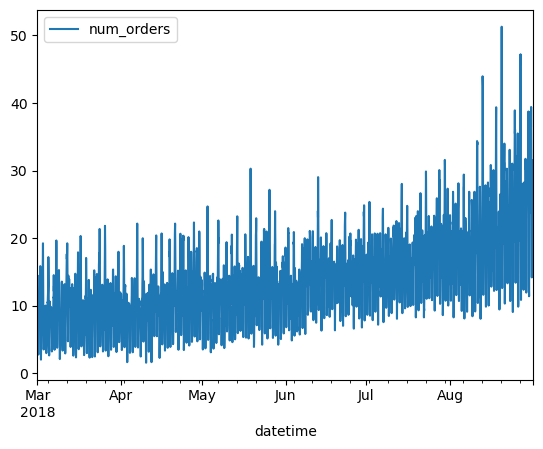

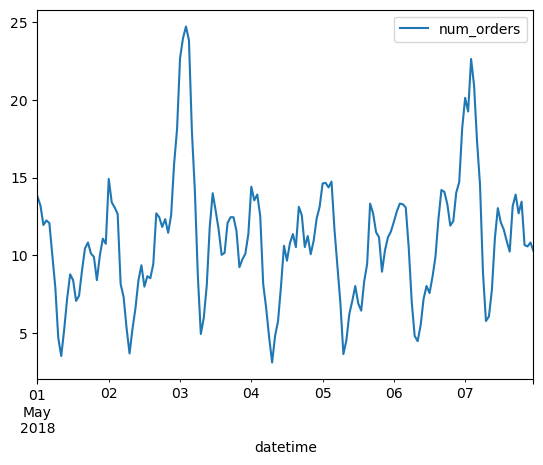

In [7]:
data.rolling(4).mean().plot()
data.rolling(4).mean()["2018-05-01":"2018-05-07"].plot()
data

Borramos entradas con datos nulos, para mantener el dataframe limpio.

Separamos nuestros datos en tendencia, estacionalidad y ruido:

Para la visualización a largo plazo, aplicaremos una media movil de mayor tamaño de ventana, abarcando una semana.

<Axes: xlabel='datetime'>

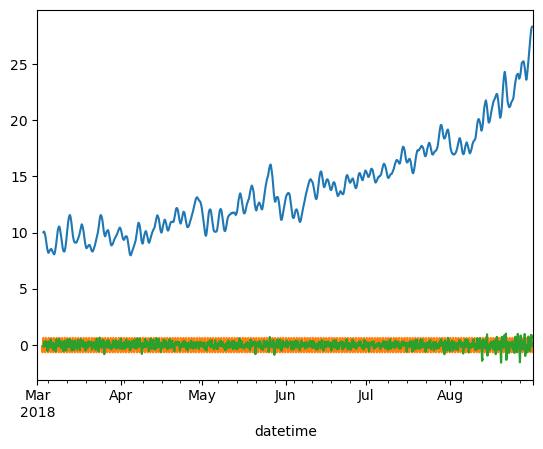

In [8]:
data.dropna(inplace=True)
decomposed = seasonal_decompose(data)

H_per_week=int((24*7)/4)


decomposed.trend.rolling(H_per_week).mean().plot()
decomposed.seasonal.rolling(H_per_week).mean().plot()
decomposed.resid.rolling(H_per_week).mean().plot()



<Axes: xlabel='datetime'>

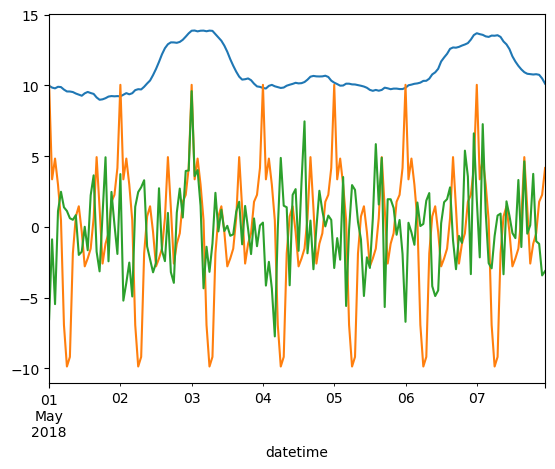

In [9]:
decomposed.trend["2018-05-01":"2018-05-07"].plot()
decomposed.seasonal["2018-05-01":"2018-05-07"].plot()
decomposed.resid["2018-05-01":"2018-05-07"].plot()

De estos ultimos graficos podemos obtener las siguientes observaciones:
- La tendencia a largo plazo es un crecimiento general en la demanada del servicio
- La estacionalidad y el residuo desaparecen a largo plazo.
- Dentro de un solo dia existen claras horas pico y horas de baja demanda.
- La tedencia no aparenta ser estacionaria, mientras que el los otros dos componentes si.

Procederemos a explorar la diferencia de la serie temporal:

,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,20.666667
2018-03-01 02:00:00,14.166667
2018-03-01 03:00:00,11.833333
2018-03-01 04:00:00,11.000000
...,...
2018-08-31 19:00:00,34.500000
2018-08-31 20:00:00,22.666667
2018-08-31 21:00:00,25.666667


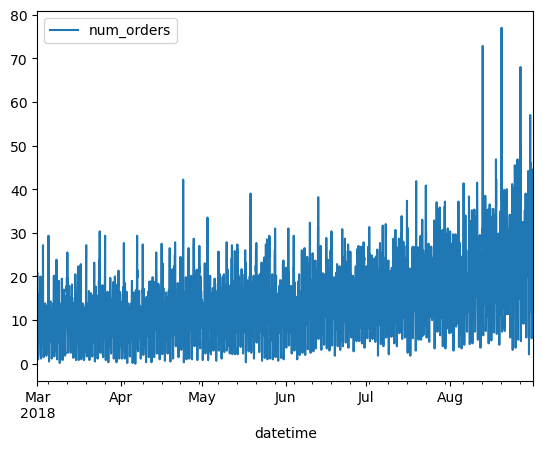

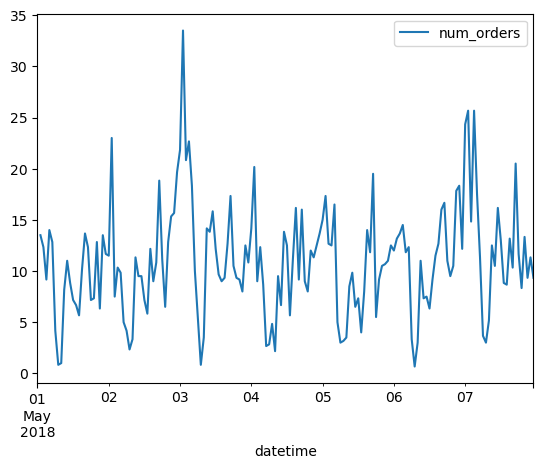

In [10]:
data.shift().plot()
data["2018-05-01":"2018-05-07"].shift().plot()
data.shift()


## Formación

Ahora usaremos los procesos del analisis para generar caracteristicas ("año", "mes", "dia", "dia de la semana", etc. ) que definan nuestro objetivo ("num_orders").

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data.dropna(inplace=True)
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)
    
    data["rolling_mean"]=data.iloc[:,0].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

    decomposed = seasonal_decompose(data.iloc[:, 0], model='additive', period=rolling_mean_size)
    
    data['trend'] = decomposed.trend
    data['seasonal'] = decomposed.seasonal
    data.dropna(inplace=True)


Aplicaremos esta función a nuestros datos pre-procesados, eligimos arbitrariamente ```max_lag=5``` y ```rolling_mean_size=5```, esto para capturar la información de las ultimas horas previas a la predicción y buscamos la correlaión entre nuestras variables. Esto se aplica antes de la separación de sets, para mantener los sets de validación y prueba completos.

In [12]:
make_features(data,5,5)
#data.corr()
data.corr()


,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,trend,seasonal
num_orders,1.000000,NaN,0.509359,0.162444,-0.020339,0.622860,0.464459,0.320267,0.247188,0.228140,0.493961,0.832274,0.009945
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.509359,NaN,1.000000,0.000418,-0.012325,0.509668,0.509794,0.509914,0.509423,0.508969,0.668245,0.667727,0.000196
day,0.162444,NaN,0.000418,1.000000,-0.014263,0.163160,0.164040,0.164066,0.163859,0.162678,0.214499,0.211218,0.001204
dayofweek,-0.020339,NaN,-0.012325,-0.014263,1.000000,-0.027925,-0.029956,-0.029379,-0.029168,-0.029454,-0.038263,-0.021368,0.000150
lag_1,0.622860,NaN,0.509668,0.163160,-0.027925,1.000000,0.622879,0.464395,0.319658,0.246428,0.696120,0.794448,-0.006099
lag_2,0.464459,NaN,0.509794,0.164040,-0.029956,0.622879,1.000000,0.622827,0.463946,0.319025,0.794553,0.696279,0.001995
lag_3,0.320267,NaN,0.509914,0.164066,-0.029379,0.464395,0.622827,1.000000,0.622749,0.463717,0.832499,0.494573,0.001824
lag_4,0.247188,NaN,0.509423,0.163859,-0.029168,0.319658,0.463946,0.622749,1.000000,0.622070,0.794220,0.393019,-0.005619
lag_5,0.228140,NaN,0.508969,0.162678,-0.029454,0.246428,0.319025,0.463717,0.622070,1.000000,0.695139,0.346917,0.009810


Donde notamos la relativamente alta autocorrelación de ```num_orders```, es decir entre ```num_orders``` y ```lag_1```

### División de data:

Ahora separaremos en conjunto de entrenamiento validación y prueba, esto con una proporcion:
- entrenamiento (train): 72%
- validación (valid): 18%
- prueba (test): 10%

In [13]:
train, test = train_test_split(data, shuffle=False, test_size=0.1) #train sirve de forma auxiliar
train, valid = train_test_split(train, shuffle=False, test_size=0.2) #train sirve de forma auxiliar


In [14]:
train_target= train.iloc[:,0]
train_features=train.drop('num_orders',axis=1)
valid_target= test.iloc[:,0]
valid_features=test.drop('num_orders',axis=1)
test_target= test.iloc[:,0]
test_features=test.drop('num_orders',axis=1)

In [15]:
train_features

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,trend,seasonal
datetime,,,,,,,,,,,,
2018-03-01 07:00:00,2018,3,1,3,2.000000,1.000000,7.166667,11.000000,11.833333,6.600000,4.533333,-0.053590
2018-03-01 08:00:00,2018,3,1,3,2.500000,2.000000,1.000000,7.166667,11.000000,4.733333,6.466667,0.050378
2018-03-01 09:00:00,2018,3,1,3,5.666667,2.500000,2.000000,1.000000,7.166667,3.666667,9.266667,-0.107985
2018-03-01 10:00:00,2018,3,1,3,11.500000,5.666667,2.500000,2.000000,1.000000,4.533333,9.766667,0.089934
2018-03-01 11:00:00,2018,3,1,3,10.666667,11.500000,5.666667,2.500000,2.000000,6.466667,9.700000,0.021262
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-11 06:00:00,2018,7,11,2,12.833333,25.500000,19.500000,25.333333,14.000000,19.433333,13.833333,-0.107985
2018-07-11 07:00:00,2018,7,11,2,13.500000,12.833333,25.500000,19.500000,25.333333,19.333333,12.200000,0.089934
2018-07-11 08:00:00,2018,7,11,2,4.666667,13.500000,12.833333,25.500000,19.500000,15.200000,13.000000,0.021262


### Escalado de caracteristicas

Tambien escalaremos las caracteristicas en preparación para algunos modelos, escalando primero para los datos de entrenamiento y usando dicha escala para los datos de validación y prueba, evitando el data leakage.

In [16]:

Numeric = list(range(len(train_features.columns)))
Numeric = [x for x in Numeric if x not in [1, 2, 3]]
scaler = StandardScaler()
scaler.fit(train_features)
train_features_scaled=scaler.transform(train_features)
valid_features_scaled=scaler.transform(valid_features)
test_features_scaled=scaler.transform(test_features)


## Entrenamos multiples modelos:
- Regresión lineal
- Arbol aleatorio de regresión
- Bosque aleatorio de regresión
- Potenciación de gradiente (CatBoost)


### Regresión lineal

In [17]:
%%time
model=LinearRegression()
model.fit(train_features_scaled,train_target)
train_predictions=model.predict(train_features_scaled)
valid_predictions=model.predict(valid_features_scaled)

train_error_lineal=root_mean_squared_error(train_predictions,train_target)
valid_error_lineal=root_mean_squared_error(valid_predictions,valid_target)
test_error_lineal = root_mean_squared_error( model.predict(test_features_scaled),test_target)

print("RECM para el conjunto de entrenamiento:",root_mean_squared_error(train_predictions,train_target)) 
print("RECM para el conjunto de prueba:",valid_error_lineal) 

RECM para el conjunto de entrenamiento: 3.366576575942065
RECM para el conjunto de prueba: 5.952150084889868
CPU times: total: 15.6 ms
Wall time: 18 ms


### Árbol aleatorio de regresión


In [18]:
%%time
model = DecisionTreeRegressor(random_state=54321)
param_grid = {
    'max_depth': [1, 3, 5, 10, None],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(train_features, train_target)
best_model = grid_search.best_estimator_
train_predictions = best_model.predict(train_features)
valid_predictions = best_model.predict(valid_features)

train_error_tree=root_mean_squared_error(train_predictions,train_target)
valid_error_tree=root_mean_squared_error(valid_predictions, valid_target)
test_error_tree = root_mean_squared_error( best_model.predict(test_features),test_target)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("RECM para el conjunto de entrenamiento:", root_mean_squared_error(train_predictions, train_target)) 
print("RECM para el conjunto de prueba:", valid_error_tree)


Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 8}
RECM para el conjunto de entrenamiento: 3.2602879029700964
RECM para el conjunto de prueba: 8.273418620649318
CPU times: total: 656 ms
Wall time: 2.71 s


### Bosque aleatorio de regresión

In [19]:
%%time
model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 400],  
    'max_depth': [5, 10, 20, 30, None],  
    'min_samples_leaf': [1, 4, 8],  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(train_features, train_target)

best_model = grid_search.best_estimator_

train_predictions = best_model.predict(train_features)
valid_predictions = best_model.predict(valid_features)

train_error_forest=root_mean_squared_error(train_predictions,train_target)
valid_error_forest=root_mean_squared_error(valid_predictions, valid_target)
test_error_forest = root_mean_squared_error( best_model.predict(test_features),test_target)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("RECM para el conjunto de entrenamiento:", root_mean_squared_error(train_predictions, train_target)) 
print("RECM para el conjunto de prueba:", valid_error_forest)



Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 300}
RECM para el conjunto de entrenamiento: 3.116621445685325
RECM para el conjunto de prueba: 7.841260588301325
CPU times: total: 1.75 s
Wall time: 51.6 s


### Potenciación de Gradiente con CatBoost


Tenemos que pasar las columnas que sean categoricas, pese a que todas las columnas son numericas, el mes, año y dia son categorias, pues no deben tener preferencia una sobre otra, aunque si orden nominal.

In [20]:
indices_categorias = [1,2,3]
print("Índices de las columnas categóricas:", indices_categorias)

Índices de las columnas categóricas: [1, 2, 3]


In [21]:
%%time
best_error = 10000
best_est = 0
best_depth = 0

# Iterar sobre diferentes hiperparámetros
for est in tqdm(range(10, 101, 10)):
    for depth in range(1, 12, 2):
        model = CatBoostRegressor(iterations=est, depth=depth, random_seed=54321, learning_rate=0.1,loss_function='RMSE',task_type="GPU", verbose=0)

        model.fit(train_features, train_target, cat_features=indices_categorias)
        valid_predictions = model.predict(valid_features)
        error = root_mean_squared_error(valid_target, valid_predictions)
        #print(f"Validación RECM para los n_estimators de {est}, depth={depth} es {error}")
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth


train_error_GB = root_mean_squared_error( model.predict(train_features),train_target)
valid_error_GB= best_error
test_error_GB = root_mean_squared_error( model.predict(test_features),test_target)

print(f"Mejores hiperparámetros: n_estimators: {best_est}, best_depth: {best_depth}")
print("RECM del mejor modelo en el conjunto de entrenamiento:", train_error_GB)
print(f"RECM del mejor modelo en el conjunto de validación: {valid_error_GB}")

100%|██████████| 10/10 [00:47<00:00,  4.78s/it]

Mejores hiperparámetros: n_estimators: 70, best_depth: 3
RECM del mejor modelo en el conjunto de entrenamiento: 2.1956904225881146
RECM del mejor modelo en el conjunto de validación: 7.999448188572034
CPU times: total: 36.9 s
Wall time: 47.8 s


## Prueba

Presentamos los errores en los sets de validación:

In [22]:
modelos = ['Regresión_lineal', 'Árbol_de_regresión', 'Bosque_de_regresión', 'Gradient_Boosting']
train_errors = [train_error_lineal, train_error_tree, train_error_forest, train_error_GB]
valid_errors = [valid_error_lineal, valid_error_tree, valid_error_forest, valid_error_GB]
test_errors = [test_error_lineal, test_error_tree, test_error_forest, test_error_GB]

df = pd.DataFrame({
    "Error de Entrenamiento": train_errors,
    'Error de Validación': valid_errors,
    'Error de Test': test_errors
}, index=modelos)

display(df)





,Error de Entrenamiento,Error de Validación,Error de Test
Regresión_lineal,3.366577,5.952150,5.952150
Árbol_de_regresión,3.260288,8.273419,8.273419
Bosque_de_regresión,3.116621,7.841261,7.841261
Gradient_Boosting,2.195690,7.999448,9.120830


Es inmediato ver que es el modelo de regresión lineal aquel que se desempeña mejor en los modelos tanto de validación como de prueba, pese a que no sea el mejor ajustado para el mismo modelo de entrenamiento. 

<Axes: title={'center': 'Errores de los Modelos'}, xlabel='Modelos', ylabel='Errores (RECM)'>

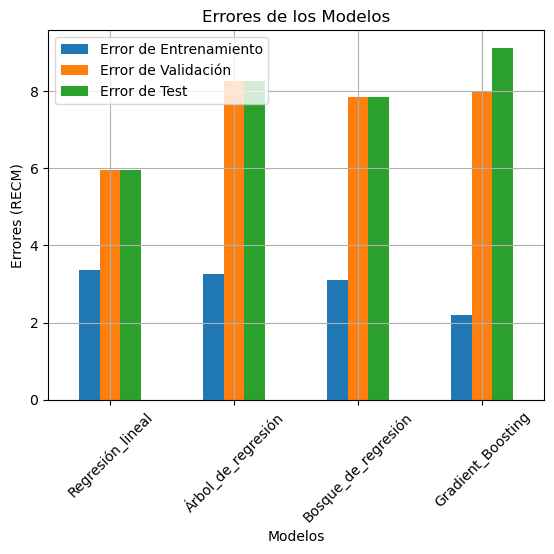

In [23]:
df.plot(kind="bar",rot=45, 
    title="Errores de los Modelos", 
    xlabel="Modelos", 
    ylabel="Errores (RECM)", 
    legend=True,
    grid=True)

# Conclusiónes y observaciones:
## Observaciones:
- Se creó un modelo que predice con un error RECM menor a 10, la cantidad de pedidos de taxis en la siguiente hora.
- Se hizo la carga, limpieza y pre-procesamiento de datos:
    - incluyendo re-muestreo
    - corrección de tipos de datos
    - seleción de indice
    
- Se hizo el analisis de datos incluyendo:
    - Calculo de media movil
    - descomposición en tendencia, estacionalidad y residuo
- se uso el analisis para crear nuevas caracteristicas, junto con caracteristicas del calendario.
- se procesaron los datos para entrenar modelos:
    - división en 3 sets y en caracteristicas y objetivos
    - Escalado de caracteristicas
- Se entrenaron cuatro modelos:
    - Regresión lineal
    - Árbol de decisión
    - Bosque aleatorio
    - CatBoost
- Evaluación de los modelos.

## Conclusiones:
- Los modelos de arbol, bosque y potenciación de gradiente se ajustan bastante al set de entrenamiento
- El mejor modelo fue **Regresión lineal** en el set de validación y de prueba, pese a que el ajuste al set de entrenamiento no es tan bueno.
- Responsabilisamos a las caracterisiticas generadas que la regresión lineal funcione de forma tan precisa.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48